<a href="https://colab.research.google.com/github/TetianaHrunyk/NeuralMetaphorsDetection/blob/master/MD2_add_pretrained_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torchtext
from torch.utils.data import DataLoader
import regex
from time import time

In [82]:
EMBEDDING_DIM = 50
PRETRAINED_VECTORS = 'glove.6B.'+str(EMBEDDING_DIM)+'d'

#PRETRAINED_VECTORS = vocab.Vectors(name = 'custom_embeddings.txt')

In [83]:
import matplotlib.pyplot as plt

def plot_errors(title, training_losses, test_loss=None, block=True):
    plt.figure(num=title)
    plt.plot(training_losses, label='Training loss')

    if test_loss:
        plt.plot([test_loss]*len(training_losses), label='Test loss')

    plt.tight_layout()
    plt.legend()
    plt.show(block=block)

# Load the data, create custom data set

In [84]:
data_path='https://raw.githubusercontent.com/TetianaHrunyk/NeuralMetaphorsDetection/master/'

In [85]:
class CustomDataset(Dataset):
  def __init__(self, path, nrows=None, tokenizer=None):
    self.text = pd.read_csv(path, header=None, names=["txt"], dtype='str', nrows=nrows)
    self.text.dropna(inplace=True)
    self.tokenizer = tokenizer

  def __len__(self):
    return self.text.shape[0]

  def __getitem__(self, idx):
    tokenized = self.tokenizer(self.text.txt.iloc[idx].rstrip('\n'))
    labels = " ".join([str(int(word.startswith("M_"))) for word in tokenized if word not in ["", " "]])
    txt = " ".join([word.replace("M_", "").lower() for word in tokenized if word not in ["", " "]])
    return labels, txt


In [86]:
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [87]:
train_data = CustomDataset(data_path+"vuamc_train.csv", nrows=2000, tokenizer=en_tokenizer)
test_data = CustomDataset(data_path+"vuamc_test.csv",  nrows=100, tokenizer=en_tokenizer)

# Build Vocab

In [88]:
def build_vocab(data):
  counter = Counter()
  for row in data:
      counter.update(row[1].split(" "))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=1, vectors=PRETRAINED_VECTORS)

In [89]:
vocab = build_vocab(train_data)

# Data Loader

In [90]:
text_pipeline = lambda x: [vocab[token] for token in x.lower().rstrip("\n").split(" ")]
label_pipeline = lambda x: [ int(l) for l in x.split(" ")]

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list = [], []
    for labels, text in batch:    
        processed_text = text_pipeline(text)
        text_tensor = torch.tensor(processed_text, dtype=torch.int64)
        text_list.append(text_tensor) 

        processed_labels=label_pipeline(labels)
        label_tensor = torch.tensor(processed_labels, dtype=torch.int64)
        label_list.append(label_tensor)

    label_list = torch.cat(label_list)
    text_list = torch.cat(text_list)
    
    return label_list.to(device), text_list.to(device)

In [92]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

# Define the model

In [93]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger_Embed, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight = nn.Parameter(vocab.vectors)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)                                                                

        self.hidden2tag =  nn.Linear(hidden_dim, tagset_size) 
        self.hidden = self.init_hidden()         

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),                                     
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds =  self.word_embeddings(sentence)                                                                                               
        lstm_out, self.hidden =  self.lstm(embeds.view(len(sentence), 1, -1))               
        tag_prediction = self.hidden2tag(lstm_out.view(len(sentence), -1))                     
        tag_scores = F.log_softmax(tag_prediction, dim=1)                       
        return tag_scores

def train(model, n_epochs, dataloader, loss_function, optimizer):
    model.train()
    train_losses = []
    for epoch in range(n_epochs):
        epoch_start = time()
        for i, (tags, sentence) in enumerate(dataloader):
            model.zero_grad()
            model.hidden = model.init_hidden()
            
            tag_scores = model(sentence)
            loss = loss_function(tag_scores, tags)
            train_losses.append(loss)
           
            loss.backward()
            optimizer.step()
        epoch_end = time()
        print('Epoch %d, loss: %0.4f, epoch took %d sec' % (epoch + 1, loss, round(epoch_end-epoch_start)))
    
    return train_losses

def report_accuracy(model, dataloader, n=None, print_data=False):
    if n==None:
      n=TRAIN_DATA_LEN
    with torch.no_grad():
        total, total_correct, total_exact_correct = 0, 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        for tags, sentence in dataloader:
            scores = model(sentence)
            out = torch.argmax(scores, dim=1).tolist()
            targets = tags.tolist()
            correct = 0
            length = len(targets)
            
            for i in range(length):
                if out[i] == targets[i]:
                  correct += 1
                  if targets[i] == 1:
                    TP += 1
                  elif targets[i] == 0:
                    TN += 1
                else:
                  if targets[i] == 1:
                    FN += 1
                  elif targets[i] == 0:
                    FP += 1

            if (print_data):
                print('data: ' + str(dict(zip(sentence, tags))))
                print('pred: ' + str(dict(zip(sentence, out))))
                print('Correct: %d of %d' % (correct, length))

            total += length
            total_correct += correct
            if correct == length:
                total_exact_correct += 1

        print('Accuracy (exact): %d / %d, %0.4f' % (total_exact_correct, n, total_exact_correct / n))
        print('Accuracy: %d / %d, %0.4f \n' % (total_correct, total, total_correct / total))
        print("{:5}| {:10} | {:10}\n{}".format("", "T", "F", "-"*30))
        print("{:5}| {:10} | {:10}".format("P", TP, FP))
        print("{:5}| {:10} | {:10}\n".format("N", TN, FN))
        
        den = 0.00001 if TP+FP == 0 else TP+FP
        print("Precision: ", round(TP/den, 2))
        den = 0.00001 if TP+FN == 0 else TP+FN
        print("Recall: ", round(TP/den, 2))
        den = 0.00001 if TP+TN+FP+FN == 0 else TP+TN+FP+FN
        print("F1: ", 2*TP/den)


In [94]:
def predict(model, text, printPred=True):
  processed_text = text_pipeline(text)
  sentence = torch.tensor(processed_text, dtype=torch.int64)
  with torch.no_grad():
    scores = model(sentence)
    out = torch.argmax(scores, dim=1).tolist()
    if printPred:
      print('Predicted labels: ' + str(dict(zip(en_tokenizer(text), out))))
    else:
      return sentence, out

# Train model

Epoch 1, loss: 0.2447, epoch took 78 sec
Epoch 2, loss: 0.2443, epoch took 78 sec
Epoch 3, loss: 0.2436, epoch took 78 sec
Epoch 4, loss: 0.2438, epoch took 78 sec
Epoch 5, loss: 0.2444, epoch took 78 sec

Training Accuracy
Accuracy (exact): 0 / 2000, 0.0000
Accuracy: 36761 / 42646, 0.8620 

     | T          | F         
------------------------------
P    |        288 |        340
N    |      36473 |       5545

Precision:  0.46
Recall:  0.05
F1:  0.013506542231393331


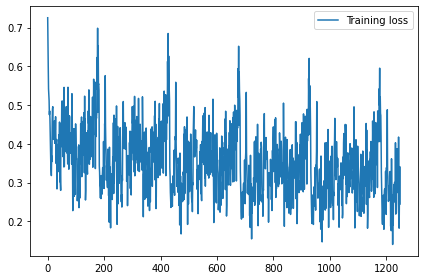


Accuracy for testing data


NameError: ignored

In [95]:
torch.manual_seed(1)

HIDDEN_DIM = 10  
n_epochs = 5      
TRAIN_DATA_LEN = len(train_data)
TEST_DATA_LEN = len(test_data)
TAGS = [0, 1]


model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(vocab), len(TAGS))

optimizer = optim.SGD(model.parameters(), lr=0.1)            
loss_function = nn.NLLLoss()      

train_losses = train(model, n_epochs, train_dataloader, loss_function, optimizer)

print("\nTraining Accuracy")
report_accuracy(model, train_dataloader)
plot_errors(training_losses=train_losses, title='Training loss')
print("\nAccuracy for testing data")
report_accuracy(model, test_dataloader)


# Interrogte the model

In [96]:
predict(model, "Some metaphorical data")

Predicted labels: {'Some': 0, 'metaphorical': 0, 'data': 1}


# Save the model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/thesis')

In [ ]:
#LOAD MODEL
#model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(vocab), len(TAGS))
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/thesis'))
#model.eval()